<a href="https://colab.research.google.com/github/benjamininden/AI-teaching-python/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting: Convolutional vs. LSTM networks

Time series forecasting is the task to predict future values of variables based on their past values over some time span. Here, we look at univariate (one variable) time series only, but the code is easily adapted to the multivariate case (a vector of variables). We train our models to predict one step ahead only. The tutorials [here](https://www.tensorflow.org/tutorials/structured_data/time_series) and [here](https://keras.io/examples/timeseries/timeseries_weather_forecasting/), from which some bits of code has been adapted for this tutorial, deal with more general cases. We will be using a [dataset](https://www.kaggle.com/robikscube/hourly-energy-consumption) that records hourly energy consumption (in Megawatts) in an area within the United States of America.

The first step in the code is to install a Python package that is missing (at least, missing on Google Colaboratory), and download and unzip the dataset. For the download to work, you will need to upload your personal Kaggle json file. Upload it when prompted, or modify the code to upload the data directly / run it on a local machine where the dataset is already present.

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download robikscube/hourly-energy-consumption
! unzip -q -d . hourly-energy-consumption.zip

Saving kaggle.json to kaggle.json
 79% 9.00M/11.4M [00:00<00:00, 26.0MB/s]
100% 11.4M/11.4M [00:00<00:00, 32.9MB/s]


We import the necessary packages, and set the length of a piece of the time series to be used as input for the model, as well as the  number of training epochs for the model.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt

inputlen = 20
epochs = 10

We use pandas to read the CSV file, but then convert the data into a one-dimensional (later reshaped into two-dimensional to fit the expected input format of the neural network) numpy array. We normalize the data, and split it into a sequence for training and a sequence for validation. We need to split these sequences into many little samples each, where each sample has a prefix of subsequent values of the right length as input, and then the next value in the sequence as expected output. These pieces can of course overlap in time, for example we can go through the whole sequence in increments of one time step to create the samples. We use  the utility fuction [timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/) for that purpose.

In [3]:
datatable = pd.read_csv('./PJME_hourly.csv', index_col=[0], parse_dates=[0])
pd.DataFrame.plot(datatable['PJME_MW'])
pd.DataFrame.plot(datatable['PJME_MW'][:200])
rawdata = datatable['PJME_MW'].values
trainidx = int(0.7 * len(rawdata))
datamean = rawdata[:trainidx].mean(axis=0)
datastd = rawdata[:trainidx].std(axis=0)
data = (rawdata - datamean) / datastd
data = data.reshape(-1, 1)
train_data = data[:trainidx-inputlen,:]
train_targets = data[inputlen:trainidx,:]
val_data = data[trainidx:-inputlen]
val_targets = data[trainidx+inputlen:]
train_ds = timeseries_dataset_from_array(train_data, train_targets, sequence_length=inputlen)
val_ds = timeseries_dataset_from_array(val_data, val_targets, sequence_length=inputlen)

The first model that we try is a 1D convolutional neural network. We use the mean squared error for the loss function.

Epoch 1/10
795/795 [==============================] - 22s 27ms/step - loss: 0.7071 - val_loss: 0.5902
Epoch 2/10
795/795 [==============================] - 21s 27ms/step - loss: 0.5642 - val_loss: 0.5300
Epoch 3/10
795/795 [==============================] - 21s 27ms/step - loss: 0.5313 - val_loss: 0.5086
Epoch 4/10
795/795 [==============================] - 21s 27ms/step - loss: 0.5161 - val_loss: 0.4901
Epoch 5/10
795/795 [==============================] - 21s 27ms/step - loss: 0.5033 - val_loss: 0.4761
Epoch 6/10
795/795 [==============================] - 21s 27ms/step - loss: 0.4945 - val_loss: 0.4672
Epoch 7/10
795/795 [==============================] - 21s 26ms/step - loss: 0.4875 - val_loss: 0.4626
Epoch 8/10
795/795 [==============================] - 21s 27ms/step - loss: 0.4821 - val_loss: 0.4575
Epoch 9/10
795/795 [==============================] - 21s 27ms/step - loss: 0.4776 - val_loss: 0.4535
Epoch 10/10
795/795 [==============================] - 21s 26ms/step - loss: 0.473

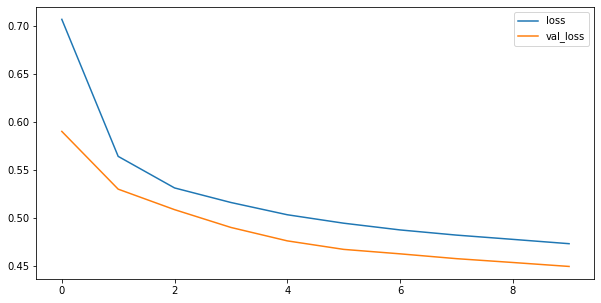

In [11]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=(5,), activation='relu', input_shape=(inputlen, 1)),
    tf.keras.layers.Conv1D(filters=16, kernel_size=(5,), activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])
cnn_model.compile(optimizer=tf.optimizers.Adam(), loss="mse")
cnn_data = cnn_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

plt.figure(figsize=(10,5))
plt.plot(cnn_data.history["loss"],label="loss")
plt.plot(cnn_data.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

Next, we use a recurrent neural network with [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (long short-term memory) cells instead of standard neurons.

Epoch 1/10
795/795 [==============================] - 29s 35ms/step - loss: 0.0946 - val_loss: 0.0267
Epoch 2/10
795/795 [==============================] - 28s 36ms/step - loss: 0.0345 - val_loss: 0.0212
Epoch 3/10
795/795 [==============================] - 28s 35ms/step - loss: 0.0291 - val_loss: 0.0204
Epoch 4/10
795/795 [==============================] - 27s 34ms/step - loss: 0.0259 - val_loss: 0.0196
Epoch 5/10
795/795 [==============================] - 27s 35ms/step - loss: 0.0238 - val_loss: 0.0190
Epoch 6/10
795/795 [==============================] - 27s 34ms/step - loss: 0.0229 - val_loss: 0.0183
Epoch 7/10
795/795 [==============================] - 27s 34ms/step - loss: 0.0221 - val_loss: 0.0183
Epoch 8/10
795/795 [==============================] - 28s 35ms/step - loss: 0.0219 - val_loss: 0.0167
Epoch 9/10
795/795 [==============================] - 27s 34ms/step - loss: 0.0213 - val_loss: 0.0172
Epoch 10/10
795/795 [==============================] - 28s 35ms/step - loss: 0.021

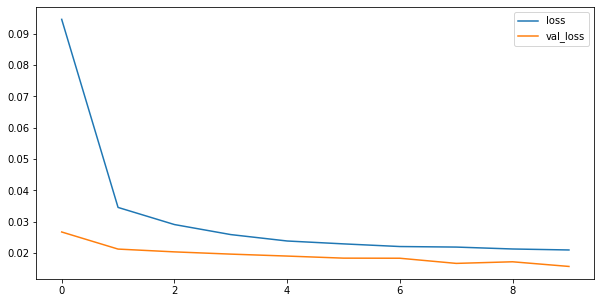

In [6]:
inputs = tf.keras.layers.Input(shape=(inputlen, 1))
lstm_out = tf.keras.layers.LSTM(64)(inputs)
dense_out = tf.keras.layers.Dense(units=64, activation='relu')(lstm_out)
do_out = tf.keras.layers.Dropout(0.2)(dense_out)
outputs = tf.keras.layers.Dense(1)(do_out)
lstm_model = tf.keras.Model(inputs=inputs, outputs=outputs)
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")
lstm_data = lstm_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

plt.figure(figsize=(10,5))
plt.plot(lstm_data.history["loss"],label="loss")
plt.plot(lstm_data.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

Even if we have trained the models to predict one step ahead only, we can run them in "autoregressive mode" (not to be confused with autoregressive models) to predict arbitrarily many steps into the future. We do this by feeding back the network's output for time *t*+1 as additional input to predict *t*+2, and so on. Of course, that way, any errors that might occur in one time step tend to get amplified in the next, so the real and predicted trajectories might diverge quickly. We get an impression of how this works for one example sequence below.

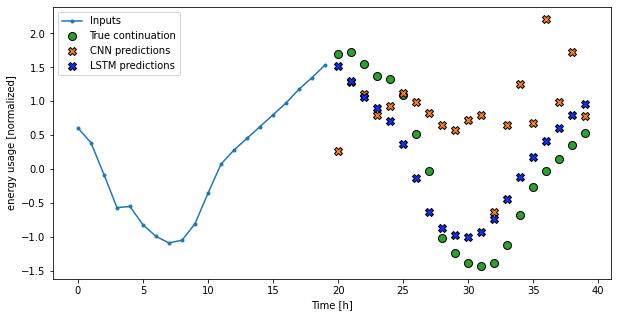

In [12]:
demo_data = data[trainidx:trainidx+inputlen,:].flatten()
cnn_data = demo_data.copy()
lstm_data = demo_data.copy()
cnn_pred = np.empty((inputlen,))
lstm_pred = np.empty((inputlen,))
for i in range(inputlen):
    cnn_pred[i] = cnn_model(cnn_data.reshape((-1, inputlen, 1))).numpy()[0,0,0]
    lstm_pred[i] = lstm_model(lstm_data.reshape((-1, inputlen, 1))).numpy()[0,0]
    cnn_data = np.append(cnn_data[1:], cnn_pred[i])
    lstm_data = np.append(lstm_data[1:], lstm_pred[i])
plt.figure(figsize=(10, 5))
plt.xlabel('Time [h]')
plt.ylabel("energy usage [normalized]")
plt.plot(range(inputlen), demo_data, label='Inputs', marker='.', zorder=-10)
plt.scatter(range(inputlen, 2*inputlen), data[trainidx+inputlen:trainidx+2*inputlen].flatten(),
            edgecolors='k', label='True continuation', c='#2ca02c', s=64)
plt.scatter(range(inputlen, 2*inputlen), cnn_data, marker='X', edgecolors='k',
            label='CNN predictions', c='#ff7f0e', s=64)
plt.scatter(range(inputlen, 2*inputlen), lstm_data, marker='X', edgecolors='k',
            label='LSTM predictions', c='#0e2fff', s=64)
plt.legend()

Overall, our LSTM network does much better than our convolutional neural network. Of course, the above comparisons of performance are dependent on many parameters and on the particular dataset, and should not be taken as general statement about the performance of different types of neural networks. There are many scientific papers with more detailed comparisons (e.g., [here](https://arxiv.org/abs/2103.12057)), as well as sets of benchmark tasks and related [competitions](http://www.neural-forecasting-competition.com/).